In [1]:
'''
https://www.tensorflow.org/get_started/mnist/pros
'''

from __future__ import print_function

import tensorflow as tf
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import shutil

In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
path = os.getcwd() + "/data/mnist"
print ("importing data to %s" % path)
mnist = input_data.read_data_sets(path, one_hot=True)

importing data to /Users/ariellev/myWS/sandbox/kaggle/notebooks/tensor-flow/data/mnist
Extracting /Users/ariellev/myWS/sandbox/kaggle/notebooks/tensor-flow/data/mnist/train-images-idx3-ubyte.gz
Extracting /Users/ariellev/myWS/sandbox/kaggle/notebooks/tensor-flow/data/mnist/train-labels-idx1-ubyte.gz
Extracting /Users/ariellev/myWS/sandbox/kaggle/notebooks/tensor-flow/data/mnist/t10k-images-idx3-ubyte.gz
Extracting /Users/ariellev/myWS/sandbox/kaggle/notebooks/tensor-flow/data/mnist/t10k-labels-idx1-ubyte.gz


In [3]:
image_width = 28
image_height = 28
image_size = np.multiply(image_width, image_height)
print("image shape [%s,%s]=%s" % (image_width, image_height, image_size))


image shape [28,28]=784


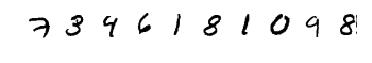

In [4]:

# display image
def display(imgs):
    n=imgs.size / image_size
    i=1
    for img in imgs:
        # (784) => (28,28)
        one_image = img.reshape(image_width,image_height)
        plt.subplot(1,n,i)
        plt.axis('off')

        plt.imshow(one_image, cmap=cm.binary)
        i=i+1

# output images
imgs=mnist.train.images[0:10]
display(imgs)

In [5]:
# Parameters
learning_rate = 0.01
epochs = 1
batch_size = 100
display_epoch = 1
notebook = "mnist-cnn"
logs_path = "%s/%s/%s" % (os.getcwd(), notebook, "logs")
model_path = "%s/%s/%s" % (os.getcwd(), notebook, "model")
checkpoint_path = "%s/%s/%s" % (os.getcwd(), notebook, "checkpoints")

os.makedirs(logs_path,exist_ok=True)
os.makedirs(model_path,exist_ok=True)
os.makedirs(checkpoint_path,exist_ok=True)


In [6]:
# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')



The first layer is a convolution, followed by max pooling. The convolution computes 32 features for each 5x5 patch. Its weight tensor has a shape of [5, 5, 1, 32]. The first two dimensions are the patch size, the next is the number of input channels (1 means that images are grayscale), and the last is the number of output channels. There is also a bias vector with a component for each output channel.


To apply the layer, we reshape the input data to a 4d tensor, with the first dimension corresponding to the number of images, second and third - to image width and height, and the final dimension - to the number of colour channels.

In [7]:
# tf Graph Input
# mnist data image of shape 28*28=784
x = tf.placeholder(tf.float32, [None, 784], name='InputData')
# 0-9 digits recognition => 10 classes
y_ = tf.placeholder(tf.float32, [None, 10], name='LabelData')

# first convolutional layer, with max pool
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

x_image = tf.reshape(x, [-1, 28, 28, 1])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
#print (h_conv1.get_shape()) # => (40000, 28, 28, 32)
h_pool1 = max_pool_2x2(h_conv1)
#print (h_pool1.get_shape()) # => (40000, 14, 14, 32)

# second convolutional layer, with max pool
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# densely connected layer
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# drop out
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# readout layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2


cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

y_softmax = tf.nn.softmax(y_conv, name='y_softmax')
values, indices = tf.nn.top_k(y_softmax, 10)

table = tf.contrib.lookup.index_to_string_table_from_tensor(tf.constant([str(i) for i in range(10)]))
prediction_classes = table.lookup(tf.to_int64(indices))


# Create a summary to monitor cost tensor
tf.summary.scalar("loss", cross_entropy)
# Create a summary to monitor accuracy tensor
tf.summary.scalar("accuracy", accuracy)

#tf.summary.histogram("prediction", pred)
#tf.summary.histogram("weights", W)

# Merge all summaries into a single op
summary_op = tf.summary.merge_all()

In [9]:
# Start training

saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # op to write logs to Tensorboard
    summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
    
    total_batches = int(mnist.train.num_examples/batch_size)
    print("total batches = %s" % (total_batches))
    for e in range(epochs):
        for i in range(total_batches):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size) 
            if i % 10 == 0:
                # record summary data
                train_accuracy, summary = sess.run([accuracy, summary_op], feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 1.0})
                summary_writer.add_summary(summary, e * total_batch + i)
                print('step %d, training accuracy %g' % (i, train_accuracy))
            else:
                _ = sess.run([train_step], feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})

        print('step %d, training accuracy %g' % (i, train_accuracy))
        p = saver.save(sess, "%s/%s.ckpt" % (checkpoint_path, notebook))
        print("Checkpoint saved to path: %s" % p)

    print('done training mnist-cnn')
    #print('test accuracy %g' % accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))
    
    # Build the signature_def_map.
    classification_inputs = tf.saved_model.utils.build_tensor_info(x)
    classification_outputs_classes = tf.saved_model.utils.build_tensor_info(prediction_classes)
    classification_outputs_scores = tf.saved_model.utils.build_tensor_info(values)

    classification_signature = (
      tf.saved_model.signature_def_utils.build_signature_def(
          inputs={
              tf.saved_model.signature_constants.CLASSIFY_INPUTS:
                  classification_inputs
          },
          outputs={
              tf.saved_model.signature_constants.CLASSIFY_OUTPUT_CLASSES:
                  classification_outputs_classes,
              tf.saved_model.signature_constants.CLASSIFY_OUTPUT_SCORES:
                  classification_outputs_scores
          },
          method_name=tf.saved_model.signature_constants.CLASSIFY_METHOD_NAME))
    
    tensor_info_x = tf.saved_model.utils.build_tensor_info(x)
    tensor_info_y = tf.saved_model.utils.build_tensor_info(y_softmax)

    # build prediction signature
    prediction_signature = (
          tf.saved_model.signature_def_utils.build_signature_def(
              inputs={'images': tensor_info_x},
              outputs={'scores': tensor_info_y},
              method_name=tf.saved_model.signature_constants.PREDICT_METHOD_NAME))

    # saving model
    legacy_init_op = tf.group(tf.tables_initializer(), name='legacy_init_op')

    if os.path.isdir(model_path):
        shutil.rmtree(model_path)
        
    builder = tf.saved_model.builder.SavedModelBuilder(model_path)
    builder.add_meta_graph_and_variables(
        sess,[tf.saved_model.tag_constants.SERVING],
        signature_def_map={
          'predict_images':
              prediction_signature,
          tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:
              classification_signature,
        },
        legacy_init_op=legacy_init_op)
    
    
    builder.save()
    print("Model exported to path: %s" % model_path)    

total batches = 550
step 0, training accuracy 0.08
step 10, training accuracy 0.22
step 20, training accuracy 0.48
step 30, training accuracy 0.69
step 40, training accuracy 0.64
step 50, training accuracy 0.74
step 60, training accuracy 0.75
step 70, training accuracy 0.83
step 80, training accuracy 0.79
step 90, training accuracy 0.83
step 100, training accuracy 0.84
step 110, training accuracy 0.91
step 120, training accuracy 0.88
step 130, training accuracy 0.91
step 140, training accuracy 0.92
step 150, training accuracy 0.87
step 160, training accuracy 0.91
step 170, training accuracy 0.91
step 180, training accuracy 0.91
step 190, training accuracy 0.87
step 200, training accuracy 0.91
step 210, training accuracy 0.89
step 220, training accuracy 0.91
step 230, training accuracy 0.93
step 240, training accuracy 0.93
step 250, training accuracy 0.93
step 260, training accuracy 0.92
step 270, training accuracy 0.95
step 280, training accuracy 0.95
step 290, training accuracy 0.88
s